In [ ]:
#|default_exp legacy 

# Pdz archaeology 

> How to read legacy pdz files.... 

**If you did not develop a headache in the previous section, then this section is for you! We need to resolve one more problem of reading ancient pdz file formats.**  

As explained in the previous section, the currently prevalent pdz file format version **pdz25** contains multiple blocks of different types and variable size. The first two bytes of a **pdz25** file decode as `25`. This is not true for old 'legacy format' pdz files. In earlier days pdz files were formatted as one single block of data. Legacy files always start with two bytes with hexadecimal code `\x01\x01`. I call this format **pdz11**.  The exact structure of these legacy files is not fixed, because some instrument detectors are equipped with 1024 channels, while other types contain 2048 channels. To complicate matters further the last part of pdz files can vary in length. 

To check a pdz file type import the `check_pdz_type()` function and provide a valid file path to a pdz file. Listing pdz files is easily done  with the standard library function `glob('*.pdz')`.       

In [ ]:
from read_pdz import check_pdz_type
from glob import glob
import os 

Let's check the pdz format for all demo data pdz files. 

In [ ]:
os.chdir('/home/frank/Work/DATA/read-pdz-demodata/')  
pdz_files = sorted(glob('*.pdz'))

print('Checking pdz file format versions: \n ')
for i, f in enumerate(pdz_files): 
    pdz_type = check_pdz_type(f)
    print(f"[{i}] {f}\n    --> format: '{pdz_type}'\n")  

Checking pdz file format versions: 
 
[0] 00066-Spectrum Only.pdz
    --> format: 'pdz25'

[1] 00067-Spectrum Only.pdz
    --> format: 'pdz25'

[2] 00068-Alloys 2.pdz
    --> format: 'pdz25'

[3] 00069-Alloys 2.pdz
    --> format: 'pdz25'

[4] 00081-Precious Metals 2.pdz
    --> format: 'pdz25'

[5] 00085-Mudrock Dual.pdz
    --> format: 'pdz25'

[6] 00086-Mudrock Dual.pdz
    --> format: 'pdz25'

[7] 00181-Restricted Materials.pdz
    --> format: 'pdz25'

[8] 00182-Restricted Materials.pdz
    --> format: 'pdz25'

[9] 1-sky sample spot.pdz
    --> format: 'pdz11_1024_channels'

[10] 2-sky left of left tree.pdz
    --> format: 'pdz11_1024_channels'

[11] 3-brown left edge sample spot.pdz
    --> format: 'pdz11_1024_channels'

[12] 59.pdz
    --> format: 'pdz11_2048_channels'

[13] A1_a.pdz
    --> format: 'pdz11_2048_channels'

[14] A7_a.pdz
    --> format: 'pdz11_2048_channels'

[15] ANALYZE_EMP-10.pdz
    --> format: 'pdz11_2048_channels'

[16] ANALYZE_EMP-11.pdz
    --> format: 'pdz

Let's now see how to parse a pdz11 file. To do so we need to import the `multiparse()` function and extended format strings for pdz11 files.  

In [ ]:
from read_pdz import multiparse, file_to_bytes, PDZ11_STRUCT_DICT

Let's take a closer look at the structure of PDZ11 files. 

```python
PDZ11_STRUCT_DICT = {
    'pdz11_2048_channels' : {'xformat': '2X-i-h-34X-2d-86X-2i-10X-2f-188X-Z-*X', 
                          'param_keys': ['pdz-version', '??', 'NumberOfChannels', '??', '??', 
                                         'eVPerChannel', '??', 'RawCounts', 'ValidCounts', '??',  'XrayVoltageInkV', 
                                         'XrayFilamentCurrentInMicroAmps', '??', 'Intensity (2048 channels)', '??']}, 
    'pdz11_1024_channels' : {'xformat': '2X-i-h-34X-2d-86X-2i-10X-2f-24X-z-*X', 
                          'param_keys': ['pdz-version', '??', 'NumberOfChannels', '??', '??', 
                                         'eVPerChannel', '??', 'RawCounts', 'ValidCounts', '??',  'XrayVoltageInkV', 
                                         'XrayFilamentCurrentInMicroAmps', '??', 'Intensity (1024 channels)', '??']} 
}
```


Given the slightly different `xformat` strings for the two types of pdz11 legacy files we can now check if we can also parse these files correctly.  

In [ ]:
#|code-fold: true
n = 13  
pdz_file = pdz_files[n]
pdz_type = check_pdz_type(pdz_file) 
arr = file_to_bytes(pdz_file)

xformat = PDZ11_STRUCT_DICT[pdz_type]['xformat']
param_keys = PDZ11_STRUCT_DICT[pdz_type]['param_keys']
print(f"file: '{pdz_file}'\n--> pdz type: '{pdz_type}'\n--> xformat string: '{xformat}'")

file: 'A1_a.pdz'
--> pdz type: 'pdz11_2048_channels'
--> xformat string: '2X-i-h-34X-2d-86X-2i-10X-2f-188X-Z-*X'


In [ ]:
parsed, tail = multiparse(xformat, arr, param_keys=param_keys)

,values,param_keys
0,b'\x01\x01',pdz-version
1,23,??
2,2048,NumberOfChannels
3,b'\xc8\xe6\xc8\xca\xd6\xd8\x02\x01?\x02\x01\x04',??
4,0.0,??
5,20.085341,eVPerChannel
6,b'\xa8\x91@\x10\x9d@\xe0j@n@\xf4\x01\x8c\x02',??
7,132513792,RawCounts
8,65538,ValidCounts
9,b'\x0e\t\x11\x07\xde\x02',??


In [ ]:
#|code-fold: true
n = 11
pdz_file = pdz_files[n]
pdz_type = check_pdz_type(pdz_file) 
arr = file_to_bytes(pdz_file)

xformat = PDZ11_STRUCT_DICT[pdz_type]['xformat']
param_keys = PDZ11_STRUCT_DICT[pdz_type]['param_keys']
print(f"file: '{pdz_file}'\n--> pdz type: '{pdz_type}'\n--> xformat string: '{xformat}'")

file: '3-brown left edge sample spot.pdz'
--> pdz type: 'pdz11_1024_channels'
--> xformat string: '2X-i-h-34X-2d-86X-2i-10X-2f-24X-z-*X'


In [ ]:
parsed, tail = multiparse(xformat, arr, param_keys=param_keys)

,values,param_keys
0,b'\x01\x01',pdz-version
1,20,??
2,1024,NumberOfChannels
3,b'\xc8\xe6\xc8\xca\xd6\xd8\x02\x01?\x02\xa6\xf...,??
4,60.76,??
5,40.0,eVPerChannel
6,b'7\xd4@\xf9\xd5@\xe0j@n@\xf0?-C\x1c\xeb\xe26\...,??
7,1001652224,RawCounts
8,519897088,ValidCounts
9,b'\xc4w\r0Y\x07',??


Although legacy pdz11 file formats contain many bytes that we can not yet read, at least we can now extract the spectral data! I will show you here how to create a plot with spectra for all variants of pdz files in our pdz zoo. We need to import `extract_spectrum()` and `matplotlib.pyplot` to create our plot.  

In [ ]:
from read_pdz import extract_spectrum
import matplotlib.pyplot as plt 

In [ ]:
df_list = [extract_spectrum(pf, to_csv=False, verbose=False) for pf in pdz_files] 

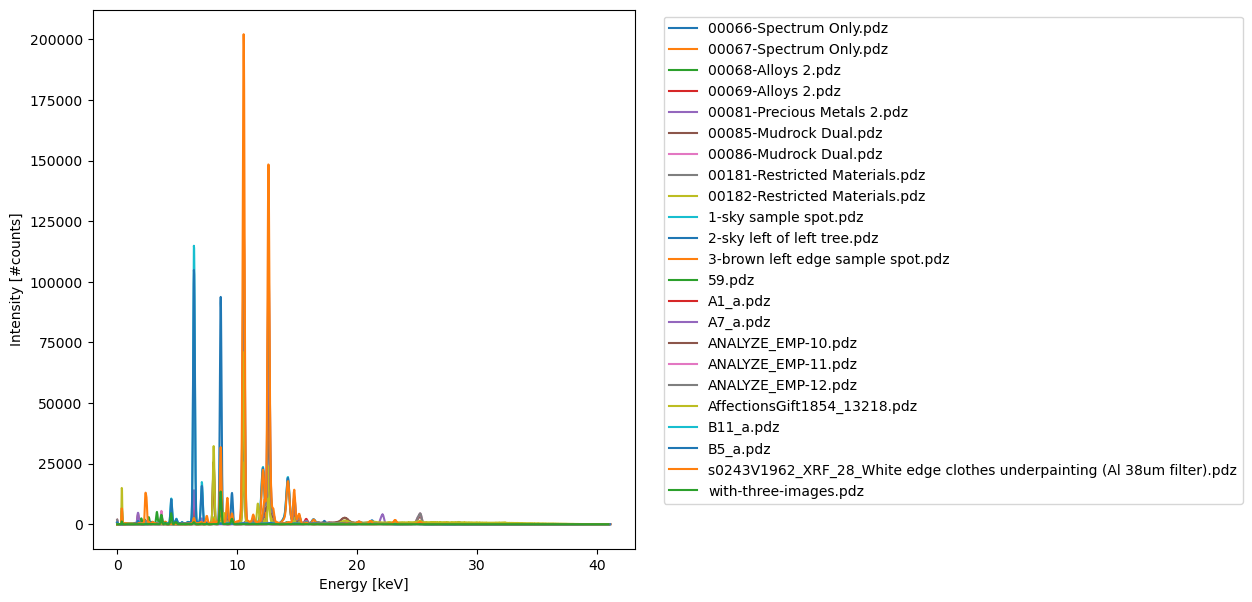

In [ ]:
#|code-fold: true 
fig, ax = plt.subplots(figsize=[7, 7])

for df in df_list: 
    df.plot(ax=ax);

ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.set_xlabel('Energy [keV]')
ax.set_ylabel('Intensity [#counts]');

## FUNCTIONS

In [ ]:
#|export 

from read_pdz import file_to_bytes, get_blocks, multiparse, parse, PDZ_25_STRUCTURE_DICT
import struct
import numpy as np
import pandas as pd
import os 

In [ ]:
#|export 

PDZ11_STRUCT_DICT = {
    'pdz11_2048_channels' : {'xformat': '2X-i-h-34X-2d-86X-2i-10X-2f-188X-Z-*X', 
                          'param_keys': ['pdz-version', '??', 'NumberOfChannels', '??', '??', 
                                         'eVPerChannel', '??', 'RawCounts', 'ValidCounts', '??',  'XrayVoltageInkV', 
                                         'XrayFilamentCurrentInMicroAmps', '??', 'Intensity (2048 channels)', '??']}, 
    'pdz11_1024_channels' : {'xformat': '2X-i-h-34X-2d-86X-2i-10X-2f-24X-z-*X', 
                          'param_keys': ['pdz-version', '??', 'NumberOfChannels', '??', '??', 
                                         'eVPerChannel', '??', 'RawCounts', 'ValidCounts', '??',  'XrayVoltageInkV', 
                                         'XrayFilamentCurrentInMicroAmps', '??', 'Intensity (1024 channels)', '??']} 
}


def check_pdz_type(pdz_file, verbose=True): 
    '''Read first two bytes and for legacy pdz files number of detector channels to check pdz file type.'''

    pdz_bytes = file_to_bytes(pdz_file) 
    file_size = len(pdz_bytes)
    first_two_bytes = struct.unpack('<h', pdz_bytes[0:2])[0] 

    if first_two_bytes == 25: 
        pdz_type = 'pdz25' 
    elif first_two_bytes == 257: 
        n_channels = struct.unpack('<h', pdz_bytes[6:8])[0] 
        if n_channels == 1024:
            pdz_type = 'pdz11_1024_channels'
        elif n_channels == 2048:
            pdz_type = 'pdz11_2048_channels'  
        else: 
            pdz_type = f'pdz11_with_unexpected_number_of_{n_channels}_channels'
    else:
        pdz_type = f'pdz_type_unknown:{first_two_bytes}'
                
    return pdz_type 


def extract_spectrum(pdz_file, to_csv=True, verbose=True): 
    '''Direct extraction of spectral data from `pdz_file`. 
    
    Should now work for both pdz25 and both pdz11 file  formats. 
    ''' 
    
    pdz_type = check_pdz_type(pdz_file)
    pdz_bytes = file_to_bytes(pdz_file) 

    # get spectral data xformat string for pdz_type 
    if pdz_type == 'pdz25': 
        xformat = PDZ_25_STRUCTURE_DICT[3]['xformat']      
    elif pdz_type == 'pdz11_2048_channels': 
        xformat = PDZ11_STRUCT_DICT['pdz11_2048_channels']['xformat']
    elif pdz_type == 'pdz11_1024_channels': 
        xformat = PDZ11_STRUCT_DICT['pdz11_1024_channels']['xformat'] 
    else: 
        return f'Unknown pdz type: {pdz_type}'
 

    # pdz25 
    if pdz_type == 'pdz25': 
        # extracting spectral data in block 
        block_list = get_blocks(pdz_bytes, verbose=False) 
        
        # select type 3 blocks
        b3_list = [b for b in block_list if b['block_type'] == 3] 
        n_spectra = len(b3_list) 
        if verbose and n_spectra > 1: 
            print('Found multiple spectral data blocks. Only parsing first spectrum. ')
        arr = b3_list[0]['bytes'] 
    
        # parsing spectrum parameters and data 
        parsed, tail = multiparse(xformat, arr, verbose=False)
        tube_keV = parsed[12] # FYI 
        delta_keV = parsed[25] / 1000
        start_keV = parsed[27] / 1000 
        n_channels = parsed[37]
        intensity = parsed[-1]
        if n_channels != 2048: 
            print(f'Found unexpected number of channels in pdz metadata: {n_channels}')
            
        stop_keV = start_keV + delta_keV * (n_channels -1)
        x_keV = np.linspace(start_keV, stop_keV, num=n_channels) 
        
        spectrum_df = pd.DataFrame(index=x_keV)
        basename = os.path.basename(pdz_file)
        spectrum_df[basename] = intensity 
        
        # TODO: Test if computed channel energies `x_keV` are reasonable, 
        # Parsing of spectrum parameters might fail 
        # if Bruker messes with file format.   
        # otherwise fall back on 0-40 keV range??  

    # pdz11_2048_channels 
    elif pdz_type == 'pdz11_2048_channels': 
        
        xformat = PDZ11_STRUCT_DICT['pdz11_2048_channels']['xformat']
        parsed, tail = multiparse(xformat, pdz_bytes, verbose=False) 

        # The problem with legacy files is that we do not know if and at which position 
        # the energy offset is stored. So we need to set start_keV=0  
        # parsing spectrum parameters and data 
        parsed, tail = multiparse(xformat, pdz_bytes, verbose=False)
        
        tube_keV = parsed[10] # FYI 
        delta_keV = parsed[5] / 1000
        start_keV = 0 
        n_channels = parsed[2]
        intensity = parsed[13]
        if n_channels != 2048: 
            print(f'Found unexpected number of channels in pdz metadata: {n_channels}')
            
        stop_keV = start_keV + delta_keV * (n_channels -1)
        x_keV = np.linspace(start_keV, stop_keV, num=n_channels) 
        
        spectrum_df = pd.DataFrame(index=x_keV)
        basename = os.path.basename(pdz_file)
        spectrum_df[basename] = intensity 
        
    
    # pdz11_1024_channels
    elif pdz_type == 'pdz11_1024_channels': 
        
        xformat = PDZ11_STRUCT_DICT['pdz11_1024_channels']['xformat']
        parsed, tail = multiparse(xformat, pdz_bytes, verbose=False) 

        # The problem with legacy files is that we do not know if and at which position 
        # the energy offset is stored. So we need to set start_keV=0  
        # parsing spectrum parameters and data 
        parsed, tail = multiparse(xformat, pdz_bytes, verbose=False)
        
        tube_keV = parsed[10] # FYI 
        delta_keV = parsed[5] / 1000
        start_keV = 0 
        n_channels = parsed[2]
        intensity = parsed[13]
        if n_channels != 1024: 
            print(f'Found unexpected number of channels in pdz metadata: {n_channels}')
            
        stop_keV = start_keV + delta_keV * (n_channels -1)
        x_keV = np.linspace(start_keV, stop_keV, num=n_channels) 
        
        spectrum_df = pd.DataFrame(index=x_keV)
        basename = os.path.basename(pdz_file)
        spectrum_df[basename] = intensity 
    
    else: 
        print(f'pdz_type: {pdz_type} Sorry, this specific pdz type is not yet implemented...')
        return 

    # saving to csv 
    if to_csv == True: 
        csv_file = f'{pdz_file}.csv' 
        print(f'Saving spectral data to: {csv_file}')
        spectrum_df.to_csv(csv_file, float_format='%10.5f')
    
    return spectrum_df           

In [ ]:
#|hide  

import pandas as pd 
import numpy as np 

In [ ]:
#|hide 

# Here is some ad hoc code to see if we can locate the energy offset. 
# It turns out that I can not find a float or double at a similar index location in these three files: 
# # ['A1_a.pdz', 'A7_a.pdz', 'ANALYZE_EMP-10.pdz'] 

import struct
import numpy as np

In [ ]:
#|hide 

n_sel = [13, 14, 15]
pdzs = [pdz_files[n] for n in n_sel]
arrs = [file_to_bytes(p) for p in pdzs] 

fmt = 'd' 
s = 0 # offset 
b = 50
n_bytes = struct.calcsize(fmt) 
iter_len = len(arr[b:400+b]) // n_bytes

arr = arrs[0]
col_list = [[t[0] for t in list(struct.iter_unpack(fmt, arr[b+s:b+s + n_bytes * iter_len]))] for arr in arrs]

row_list = [row for row in zip(*col_list)]

print(len(row_list))
for i, r in enumerate(row_list): 
    print(f'[{b+s+n_bytes*i}:{b+s+n_bytes*(i+1)}] {r}')

50
[50:58] (20.08534130941999, 20.069613078149022, 20.01027396897461)
[58:66] (0.0, 0.0, 0.0)
[66:74] (0.0, 0.0, 0.0)
[74:82] (1130.0, 1130.0, 0.0)
[82:90] (1860.0, 1860.0, 0.0)
[90:98] (0.0, 0.0, 0.0)
[98:106] (215.0, 215.0, 0.0)
[106:114] (240.0, 240.0, 0.0)
[114:122] (0.0, 0.0, 5.103821572200691e-303)
[122:130] (0.0, 0.0, 0.0)
[130:138] (2.47e-321, 2.47e-321, 0.0)
[138:146] (3.22e-321, 3.24e-321, 3.25e-321)
[146:154] (1.9469417482553493e-308, 1.9469417482553493e-308, 1.8078767544182257e-308)
[154:162] (7.339509872616912e-295, 1.7244678902609201e-307, 1.06100145719e-312)
[162:170] (32768.00806236267, 32768.00806236267, 734003.1291503906)
[170:178] (nan, nan, 7.750368816794189e-304)
[178:186] (0.0, 0.0, 20.01027396897461)
[186:194] (0.0, 0.0, 0.0)
[194:202] (2.0160327737175e-311, 2.0160327737175e-311, 2.0202767652994e-311)
[202:210] (3.87115692240695e-310, 3.9379997898477e-310, 8.95588323813595e-310)
[210:218] (1.9734560855977e-311, 1.9734560855977e-311, 1.941626148733e-311)
[218:226]

In [ ]:
#|hide 
n_sel = [13, 14, 15]
pdzs = [pdz_files[n] for n in n_sel]
arrs = [file_to_bytes(p) for p in pdzs] 

fmt = 'f' 
s = 0 # offset 
b = 58
n_bytes = struct.calcsize(fmt) 
iter_len = len(arr[b:400+b]) // n_bytes

arr = arrs[0]
col_list = [[t[0] for t in list(struct.iter_unpack(fmt, arr[b+s:b+s + n_bytes * iter_len]))] for arr in arrs]

row_list = [row for row in zip(*col_list)]

print(len(row_list))
for i, r in enumerate(row_list): 
    print(f'[{b+s+n_bytes*i}:{b+s+n_bytes*(i+1)}] {r}')

100
[58:62] (0.0, 0.0, 0.0)
[62:66] (0.0, 0.0, 0.0)
[66:70] (0.0, 0.0, 0.0)
[70:74] (0.0, 0.0, 0.0)
[74:78] (0.0, 0.0, 0.0)
[78:82] (4.5517578125, 4.5517578125, 0.0)
[82:86] (0.0, 0.0, 0.0)
[86:90] (4.908203125, 4.908203125, 0.0)
[90:94] (0.0, 0.0, 0.0)
[94:98] (0.0, 0.0, 0.0)
[98:102] (0.0, 0.0, 0.0)
[102:106] (3.669921875, 3.669921875, 0.0)
[106:110] (0.0, 0.0, 0.0)
[110:114] (3.71875, 3.71875, 0.0)
[114:118] (0.0, 0.0, 2.2959182325159954e-39)
[118:122] (0.0, 0.0, 3.159144711210905e-38)
[122:126] (0.0, 0.0, 0.0)
[126:130] (0.0, 0.0, 0.0)
[130:134] (7.006492321624085e-43, 7.006492321624085e-43, 0.0)
[134:138] (0.0, 0.0, 0.0)
[138:142] (9.136465987397807e-43, 9.1925179259708e-43, 9.220543895257296e-43)
[142:146] (0.0, 0.0, 0.0)
[146:150] (1.865044178108472e-40, 1.865044178108472e-40, 1.1048439651076517e-39)
[150:154] (1.2856983475103413e-39, 1.2856983475103413e-39, 1.1938642526508144e-39)
[154:158] (1.5612160463720295e-39, 2.7550774964259153e-39, 1.010193260334832e-39)
[158:162] (3.261

In [ ]:
#|hide
pd.set_option('display.max_rows', None)